In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]= '3'

import numpy as np
import matplotlib.pyplot as plt
import multielec_src.fitting as fitting
import statsmodels.api as sm
import jax
import jax.numpy as jnp

In [2]:
def sample_spikes(p_true, t):
    p_true, t = np.array(p_true), np.array(t).astype(int)
    
    p_empirical = []
    for i in range(len(p_true)):
        if t[i] == 0:
            p_empirical += [0.5]
        
        else:
            p_empirical += [np.mean(np.random.choice(np.array([0, 1]), 
                                                 p=np.array([1-p_true[i], p_true[i]]), 
                                                 size=t[i]))]
        
    p_empirical_array = np.array(p_empirical)

    return p_empirical_array

In [3]:
NUM_TRIALS = 20
ZERO_THRESH = 1e-4
zero_prob = 0.01
slope_bound = 10
w0 = np.random.normal(-6, scale=1)
w1 = np.clip(np.random.normal(-5, scale=5), a_min=-slope_bound, a_max=w0/2)
w_true = np.array([[w0, w1]])

X = -np.linspace(0, 4, 41).reshape(-1, 1)
T = np.ones(len(X), dtype=int) * NUM_TRIALS
probs_true = fitting.sigmoidND_nonlinear(sm.add_constant(X, has_constant='add'),
                                         w_true)
probs_empirical = sample_spikes(probs_true, T)
good_inds = np.where((probs_empirical > ZERO_THRESH) & (probs_empirical < 1 - ZERO_THRESH))

ms = [1]
w_inits = []
for m in ms:
    w_init = np.array(np.random.normal(size=(m, X.shape[1]+1)))
    z = 1 - (1 - zero_prob)**(1/len(w_init))
    w_init[:, 0] = np.clip(w_init[:, 0], None, np.log(z/(1-z)))
    w_init[:, 1:] = np.clip(w_init[:, 1:], -slope_bound, slope_bound)
    w_inits.append(w_init)

w_curr, _, _ = fitting.fit_surface(X[good_inds], probs_empirical[good_inds], T[good_inds], w_inits)
probs_curr = fitting.sigmoidND_nonlinear(sm.add_constant(X, has_constant='add'),
                                         w_curr)


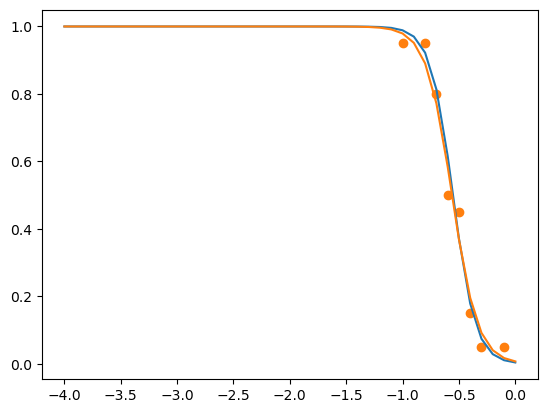

In [4]:
plt.figure()
plt.plot(X.flatten(), probs_true)
plt.plot(X.flatten(), probs_curr)
plt.scatter(X.flatten()[good_inds], probs_empirical[good_inds], c='tab:orange')

In [5]:
jacobian = jax.jacfwd(fitting.activation_probs, argnums=1)(jnp.array(sm.add_constant(X, has_constant='add')), 
                                                           jnp.array(w_curr)).reshape((len(X), w_curr.shape[0]*w_curr.shape[1]))
I_p = jnp.array(np.diag(T / (probs_curr * (1 - probs_curr))))
I_w = jacobian.T @ (I_p @ jacobian)
var_p = jacobian @ jnp.linalg.solve(I_w, jacobian.T)


In [17]:
jnp.sum(jnp.multiply(jacobian.T, jnp.linalg.solve(I_w, jacobian.T)), axis=0)

DeviceArray([1.99842725e-05, 7.93235813e-05, 2.82523455e-04,
             8.36125808e-04, 1.82180211e-03, 2.63740076e-03,
             2.68317293e-03, 1.98860234e-03, 9.92523856e-04,
             3.56030039e-04, 1.03711187e-04, 2.67325304e-05,
             6.39589189e-06, 1.45719423e-06, 3.20728191e-07,
             6.87313815e-08, 1.44410786e-08, 2.98357605e-09,
             6.07800088e-10, 1.23459978e-10, 2.38007305e-11,
             4.50907020e-12, 1.05480772e-12, 1.89721231e-13,
             5.29790411e-14, 0.00000000e+00, 0.00000000e+00,
             0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
             0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
             0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
             0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
             0.00000000e+00, 0.00000000e+00], dtype=float32)

In [16]:
jnp.diagonal(var_p)

DeviceArray([1.99842725e-05, 7.93235813e-05, 2.82523426e-04,
             8.36125808e-04, 1.82180211e-03, 2.63740076e-03,
             2.68317270e-03, 1.98860234e-03, 9.92523856e-04,
             3.56030039e-04, 1.03711187e-04, 2.67325322e-05,
             6.39589189e-06, 1.45719423e-06, 3.20728162e-07,
             6.87313815e-08, 1.44410786e-08, 2.98357583e-09,
             6.07800088e-10, 1.23459978e-10, 2.38007287e-11,
             4.50906977e-12, 1.05480772e-12, 1.89721231e-13,
             5.29790377e-14, 0.00000000e+00, 0.00000000e+00,
             0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
             0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
             0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
             0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
             0.00000000e+00, 0.00000000e+00], dtype=float32)

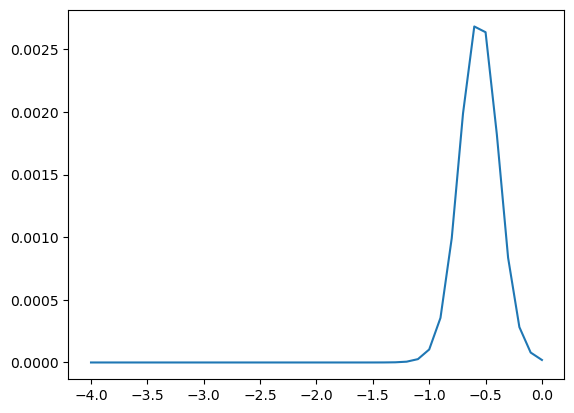

In [10]:
plt.plot(X.flatten(), np.array(jnp.diagonal(var_p)))